<a href="https://colab.research.google.com/github/jo5382/image-classification/blob/main/gradcams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Saliency Analysis</h1>

In [ ]:
#Import required dependencies.
import os
import cv2
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img

from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
#The grad-cam functions and implementation credit goes to https://github.com/tabayashi0117/Score-CAM
#This is only re-modified for this work.

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)

    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    weights = pred_from_masked_input_array[:,cls]
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)
    cam /= np.max(cam)

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

### Load the model for the CAM algorithm

In [ ]:
#Load the model to evaluate
structure = ['MFuRe', 'MFNR']
dropout = ['alpha', 'standard', 'no']

architecture = structure[0]
condition = dropout[0]

model = load_model('models/' + architecture + 'CNN' + '_'+ condition + '_do/' + 'model.h5')
print("**The model is successfully loaded**")
print("====================================")
print()
print("**Review as needed**")
print("------------------------------------")
model._name = architecture + 'CNN' + '_'+ condition + '_do'
model.summary()

**The model is successfully loaded**

**Review as needed**
------------------------------------
Model: "MFuReCNN_alpha_do"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_DCNN_A_DCNN_B_DCNN_C_DC [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1_DCNN_A (Rescaling)  (None, 224, 224, 3)  0           input_1_DCNN_A_DCNN_B_DCNN_C_DCNN
__________________________________________________________________________________________________
normalization_1_DCNN_A (Normali (None, 224, 224, 3)  7           rescaling_1_DCNN_A[0][0]         
__________________________________________________________________________________________________
stem_conv_pad_DCNN_A (ZeroPaddi (None, 225, 225, 3)  0           normalization_1_DCNN

### Set gradient source

In [ ]:
#Make sure to get the CORRECT Layer for the Grad-CAM depending on the model.

#Change only the numbers on the 'n' on 'model.layers[n].name'
last_conv_layer_name = model.layers[-4].name

#####DO NOT CHANGE ANYTHING#####
if architecture == structure[0]:
    required_layer = 'ResidualFusionLayer'
else:
    required_layer = 'FusionLayer'

if last_conv_layer_name == required_layer:
    print("CORRECT LAYER SELECTED:", last_conv_layer_name)
else:
    print("INCORRECT LAYER SELECTED:", last_conv_layer_name)
    print("Please Reselect")

CORRECT LAYER SELECTED: ResidualFusionLayer


### CAM preparation

In [ ]:
#Initial testing and loading
dict_case = {0: 'normal',
             1: 'ulcer',
             1: 'polyp',
             2: 'esophagitis'}

###########################################################################################
#JUST REPLACE THE value on the `dict_case` dictionary depending on the needed case sample.

case = dict_case[1]

###########################################################################################

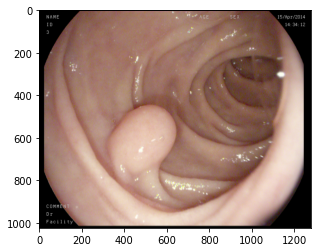

In [ ]:
#Display the selected case
orig_img = np.array(load_img('test_samples/' + case + '.jpg'),dtype=np.uint8)
orig_img = orig_img / 255.0
plt.imshow(orig_img)
plt.show()

### Score-CAM Heatmap

c:\users\franc\anaconda3\envs\replicate\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


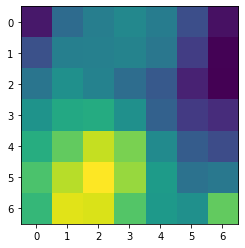

In [ ]:
#Print the heatmap result of the selected case using Score-CAM
img_array = read_and_preprocess_img('test_samples/' + case + '.jpg', size=(224,224))

score_cam = ScoreCam(model,img_array, last_conv_layer_name)

plt.imshow(score_cam)
plt.show()

# Grad-CAM++, Score-CAM, Faster-Score-CAM

In [ ]:
def build_model():
    return load_model('models/' + architecture + 'CNN' + '_'+ condition + '_do/' + 'model.h5')

In [ ]:
#YOU MAY SELECT A NEW MODEL TO TEST FROM HERE.

from tensorflow.keras.models import load_model

#Load the model to evaluate

structure = ['MFuRe', 'MFNR']
dropout = ['alpha', 'standard', 'no']

architecture = structure[0]
condition = dropout[0]

model = load_model('models/' + architecture + 'CNN' + '_'+ condition + '_do/' + 'model.h5')
print("**The model is successfully loaded**")
print("====================================")
print()
print("**Review as needed**")
print("------------------------------------")
model._name = architecture + 'CNN' + '_'+ condition + '_do'
model.summary()

**The model is successfully loaded**

**Review as needed**
------------------------------------
Model: "MFuReCNN_alpha_do"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_DCNN_A_DCNN_B_DCNN_C_DC [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1_DCNN_A (Rescaling)  (None, 224, 224, 3)  0           input_1_DCNN_A_DCNN_B_DCNN_C_DCNN
__________________________________________________________________________________________________
normalization_1_DCNN_A (Normali (None, 224, 224, 3)  7           rescaling_1_DCNN_A[0][0]         
__________________________________________________________________________________________________
stem_conv_pad_DCNN_A (ZeroPaddi (None, 225, 225, 3)  0           normalization_1_DCNN

In [ ]:
#Make sure to get the CORRECT Layer for the Grad-CAM depending on the model.

#Change only the numbers on the 'n' on 'model.layers[n].name'
last_conv_layer_name = model.layers[-4].name

#####DO NOT CHANGE ANYTHING#####
if architecture == structure[0]:
    required_layer = 'ResidualFusionLayer'
else:
    required_layer = 'FusionLayer'

if last_conv_layer_name == required_layer:
    print("FuRB LAYER SELECTED:", last_conv_layer_name)
else:
    print("THIS IS NOT THE FuRB LAYER:", last_conv_layer_name)
    print("Reselect if needed")

FuRB LAYER SELECTED: ResidualFusionLayer


The model diagnosed the case with a confidence score of : 98%
THE FOLLOWING WILL TAKE A WHILE, PLEASE BE PATIENT.


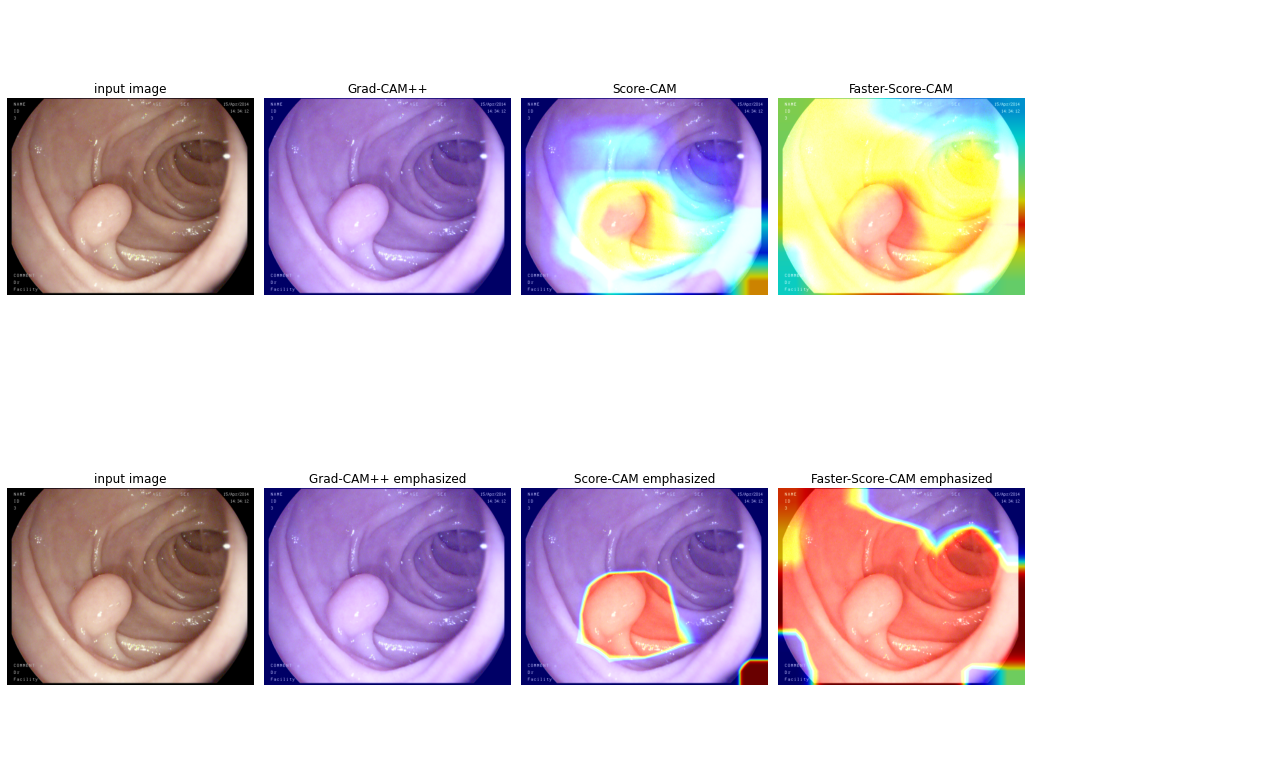

CAMs successfully loaded and finished


In [ ]:
#PRINT THE CAMs using various algorithms
case_dict = {0: 'normal',
            1: 'ulcer',
            2: 'polyp',
            3: 'esophagitis'}

#########################################################

#Please select a number only.
case = case_dict[2]

##########################################################

img_path = 'test_samples/' + case + '.jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224, 224))
img_array = img_array / 255.0

preds = model.predict(img_array)
preds = np.argmax(preds[0])
score = max(model.predict(img_array)[0]) * 100
print("The model diagnosed the case with a confidence score of :", str(round(score)) + '%')

print("THE FOLLOWING WILL TAKE A WHILE, PLEASE BE PATIENT.")

grad_cam_plus_plus=GradCamPlusPlus(model,img_array, last_conv_layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array, last_conv_layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array, last_conv_layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))

faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)
grad -= np.min(grad)
grad /= np.max(grad)

grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(18, 11))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")

ax[0,1].imshow(grad_cam_plus_plus_superimposed)
ax[0,1].set_title("Grad-CAM++")

ax[0,2].imshow(score_cam_superimposed)
ax[0,2].set_title("Score-CAM")

ax[0,3].imshow(faster_score_cam_superimposed)
ax[0,3].set_title("Faster-Score-CAM")

ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")

ax[1,1].imshow(grad_cam_plus_plus_emphasized)
ax[1,1].set_title("Grad-CAM++ emphasized")

ax[1,2].imshow(score_cam_emphasized)
ax[1,2].set_title("Score-CAM emphasized")

ax[1,3].imshow(faster_score_cam_emphasized)
ax[1,3].set_title("Faster-Score-CAM emphasized")

for i in range(2):
    for j in range(5):
        ax[i,j].axis('off')

plt.tight_layout()
plt.savefig('gradcam/' + architecture + 'CNN' + '_'+ condition + '_do/' + case + '_case_FULL_cams.tif',
            bbox_inches=None,
            pad_inches=0.0,
            dpi=300,
            format='tif')
plt.show()

print("CAMs successfully loaded and finished")

# processing time

In [ ]:
print("Grad-CAM")
%timeit grad_cam = GradCam(model, img_array, last_conv_layer_name)
print("Grad-CAM++")
%timeit grad_cam_plus_plus = GradCamPlusPlus(model, img_array, last_conv_layer_name)
print("Score-Cam")
%timeit score_cam = ScoreCam(model, img_array, last_conv_layer_name)
print("Faster-Score-Cam N=10")
%timeit faster_score_cam = ScoreCam(model, img_array, last_conv_layer_name, max_N=10)
print("Faster-Score-Cam N=3")
%timeit faster_score_cam = ScoreCam(model, img_array, last_conv_layer_name, max_N=3)

Grad-CAM
1.39 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Grad-CAM++
1.44 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Score-Cam
2.19 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Faster-Score-Cam N=10
1.49 s ± 93.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Faster-Score-Cam N=3
1.24 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Visualize other images from the `/test samples` folder.

In [ ]:
#Test any images in the test folder.

architecture = architecture

import matplotlib.pyplot as plt
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import load_img
from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

model = build_model()

#These can be changed based on the test files within the `test samples` folder.
img_basenames = ["normal.jpg", "ulcer.jpg", "polyp.jpg", "esophagitis.jpg"]

print("PLEASE BE PATIENT THIS WILL TAKE A WHILE TO FINISH....")

#The images from the `test_samples` folder will be used.
for basename in img_basenames:
    img_path = f'./test_samples/{basename}'
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = read_and_preprocess_img(img_path, size=(224, 224))
    img_array = img_array / 255.0

    predictions = model.predict(img_array)

    grad_cam_plus_plus=GradCamPlusPlus(model,img_array, last_conv_layer_name)
    grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

    score_cam=ScoreCam(model,img_array, last_conv_layer_name)
    score_cam_superimposed = superimpose(img_path, score_cam)

    faster_score_cam=ScoreCam(model,img_array, last_conv_layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)

    grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))

    score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))

    faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))

    print(img_path)
    fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(18, 7))
    ax[0,0].imshow(orig_img)
    ax[0,0].set_title("input image")

    ax[0,1].imshow(grad_cam_plus_plus_superimposed)
    ax[0,1].set_title("Grad-CAM++")

    ax[0,2].imshow(score_cam_superimposed)
    ax[0,2].set_title("Score-CAM")

    ax[0,3].imshow(faster_score_cam_superimposed)
    ax[0,3].set_title("Faster-Score-CAM")

    for i in range(2):
        for j in range(5):
            ax[i,j].axis('off')
    plt.tight_layout()

    plt.show()

    print("CAMs successfully loaded and finished")